In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from itertools import combinations 
import ast
import math

from sklearn.preprocessing import StandardScaler, normalize
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
%matplotlib inline
warnings.filterwarnings('ignore')

### Retrieve data

In [2]:
# Read dataset
data_folder = './data/'
data=pd.read_csv(data_folder + 'marketing_campaign.csv',header=0,sep=';', index_col = 'ID')

In [3]:
data.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,4/9/2012,58,635,88,...,7,0,0,0,0,0,0,3,11,1
2174,1954,Graduation,Single,46344.0,1,1,8/3/2014,38,11,1,...,5,0,0,0,0,0,0,3,11,0
4141,1965,Graduation,Together,71613.0,0,0,21/8/2013,26,426,49,...,4,0,0,0,0,0,0,3,11,0
6182,1984,Graduation,Together,26646.0,1,0,10/2/2014,26,11,4,...,6,0,0,0,0,0,0,3,11,0
5324,1981,PhD,Married,58293.0,1,0,19/1/2014,94,173,43,...,5,0,0,0,0,0,0,3,11,0


### Analyze data and rename columns

In [4]:
# Calculate client's age
data['Age'] = 2021 - data['Year_Birth']

# Calculate total spent
data['Total_Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

#Seniority variable creation
last_date = date(2021, 12, 13)

In [5]:
# Calculate clients's seniority
data['Seniority']=pd.to_datetime(data['Dt_Customer'], dayfirst=True, format='%d/%m/%Y')
data['Seniority'] = pd.to_numeric(data['Seniority'].dt.date.apply(lambda x: (last_date - x)).dt.days, downcast='integer')

# Rename some columns
data=data.rename(columns={'NumWebPurchases': "Web_Purchases",
                          'NumCatalogPurchases':'Catalog_Purchases',
                          'NumStorePurchases':'Store_Purchases', 
                          'NumWebVisitsMonth':'Web_Visits_Month',
                          'MntWines': "Wines",
                          'MntFruits':'Fruits',
                          'MntMeatProducts':'Meat',
                          'MntFishProducts':'Fish',
                          'MntSweetProducts':'Sweets',
                          'MntGoldProds':'Gold'})
data['Marital_Status'].replace({'Absurd':'Alone','YOLO':'Alone'}, inplace=True)

# Calculate the amount of children that a client has
data['Children'] = data['Kidhome'] + data['Teenhome']
data['Has_Child'] = (data.Children > 0)*1
# Filter just relevant client's features
data=data[['Age','Education','Marital_Status','Income','Total_Spent','Seniority','Has_Child', 'Children', 'Wines','Fruits','Meat','Fish','Sweets','Gold','Web_Purchases','Catalog_Purchases','Store_Purchases','Web_Visits_Month']]
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


In [6]:
def plot_hist(columns, bins):
    features = len(columns)
    COLUMNS = 4
    ROWS = math.ceil(features/COLUMNS)

    fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(16,10))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        current_row = i//COLUMNS
        # Get the axis where to add the plot
        ax = axs[current_row, current_column]
        data[columns[i]].hist(bins=bins[i], ax=ax, alpha=0.6)
        ax.set_title(columns[i])
        
    plt.tight_layout()

In [7]:
def plot_bars(columns):
    features = len(columns)
    COLUMNS = 4
    fig, axs = plt.subplots(1, COLUMNS, figsize=(16,4))
    
    for i in range(0, features):
        current_column = i % COLUMNS
        ax = axs[current_column]
        data[columns[i]].value_counts().plot(ax=ax, kind='bar')
        ax.set_title(columns[i])
        
    plt.tight_layout()

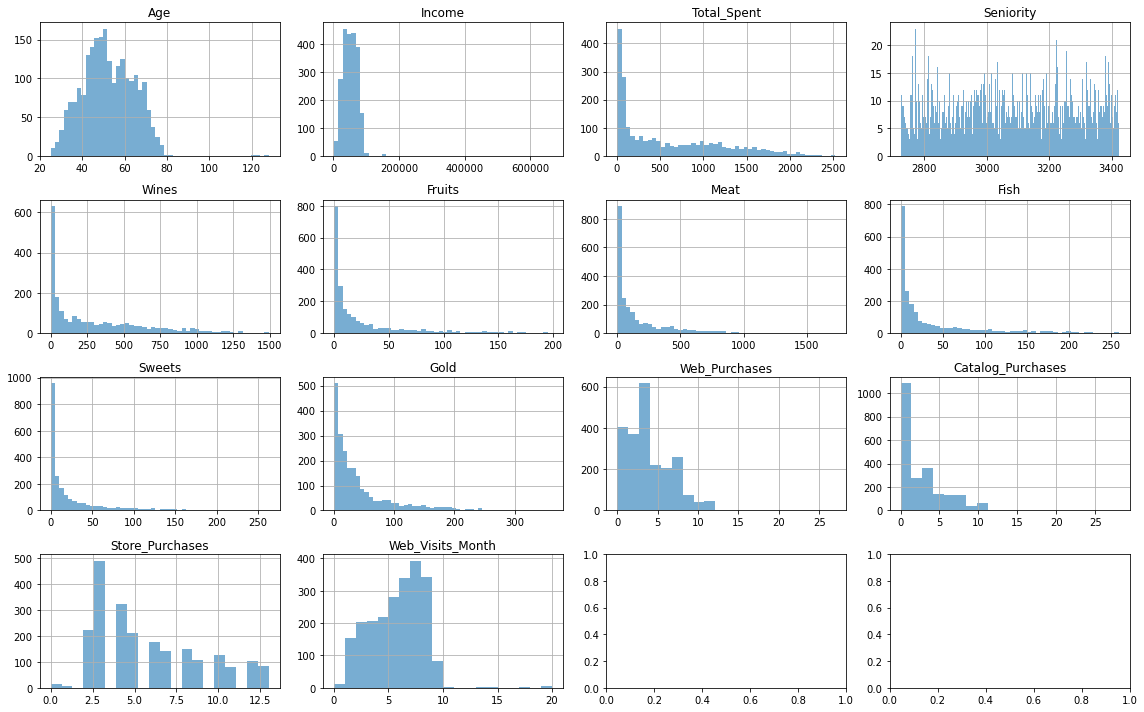

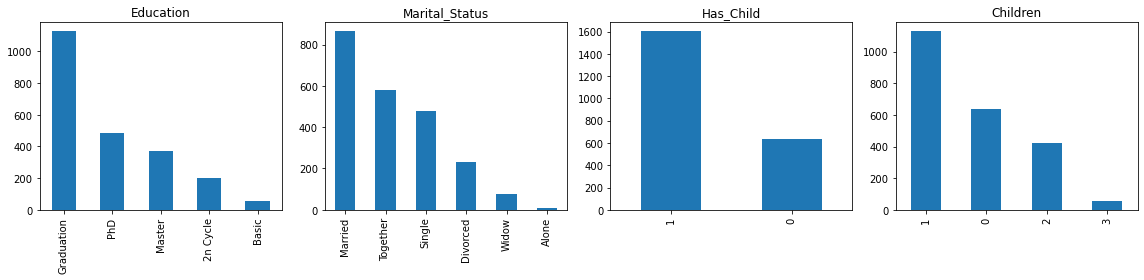

In [8]:
# Plot features after cleaning the data
hist_columns = ['Age', 'Income', 'Total_Spent', 'Seniority', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
bar_columns = ['Education', 'Marital_Status', 'Has_Child', 'Children']

bins = [50, 50, 50, 250, 50, 50, 50, 50, 50, 50, 20, 20, 20, 20]

plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### Clean data

In [9]:
# Check amount of initial null values
print('Amount of null values',len(data[data.isna().any(axis=1)]))
print(data.mean().mean())

Amount of null values 24
3538.0089573797704


In [10]:
# Fill null values with mean income amount according its education level
data['Income'].fillna(data.groupby('Education')['Income'].transform('mean'), inplace=True)

In [11]:
# Check the amount of null values after cleaning the data
print('Amount of null values after cleaning the data',len(data[data.isna().any(axis=1)]))

Amount of null values after cleaning the data 0


In [12]:
# Remove outliers
data = data[data['Age'] < 100]
data = data[data['Income'] < 600000]

In [13]:
data.head()

,Age,Education,Marital_Status,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,Catalog_Purchases,Store_Purchases,Web_Visits_Month
ID,,,,,,,,,,,,,,,,,,
5524,64,Graduation,Single,58138.0,1617,3387,0,0,635,88,546,172,88,88,8,10,4,7
2174,67,Graduation,Single,46344.0,27,2837,1,2,11,1,6,2,1,6,1,1,2,5
4141,56,Graduation,Together,71613.0,776,3036,0,0,426,49,127,111,21,42,8,2,10,4
6182,37,Graduation,Together,26646.0,53,2863,1,1,11,4,20,10,3,5,2,0,4,6
5324,40,PhD,Married,58293.0,422,2885,1,1,173,43,118,46,27,15,5,3,6,5


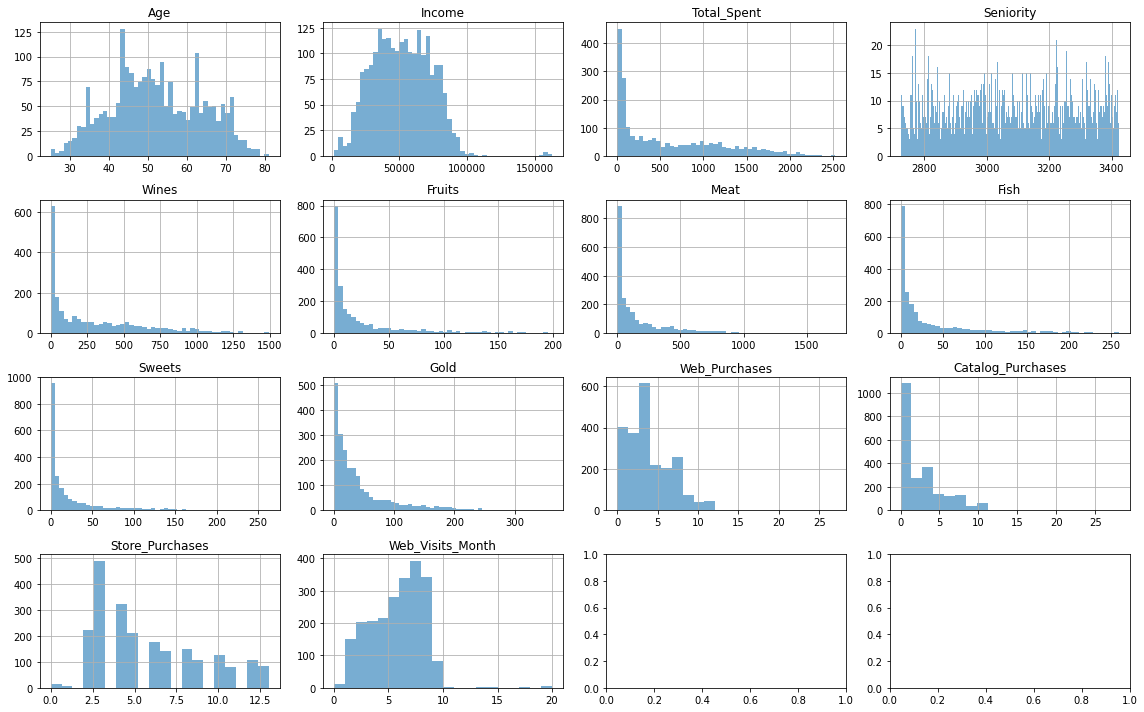

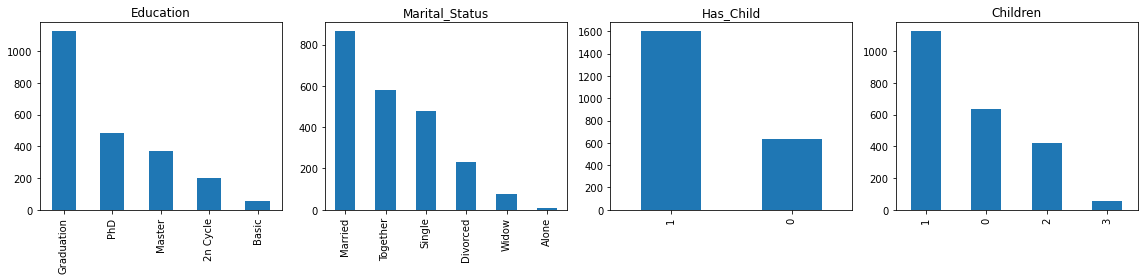

In [14]:
# Plot again after cleaning the data
plot_hist(hist_columns, bins)
plot_bars(bar_columns)

### Create Labels

In [15]:
# Adding labels to DataFrame
data['Buy_More_Online'] = (data['Web_Purchases'] > data['Store_Purchases'])*1
data['Spent_More_In_Wines_Than_Meat'] = (data['Wines'] > data['Meat'])*1

In [16]:
data = pd.get_dummies(data)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,1,0,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,1,0,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,1,0,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,1,0,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,1,0,0,1,0,0,0


### Prepare data

In [17]:
# Get own labels
y_online = data['Buy_More_Online']
y_spent = data['Spent_More_In_Wines_Than_Meat']

In [18]:
# Drop label columns
data.drop(columns=['Buy_More_Online', 'Spent_More_In_Wines_Than_Meat'], inplace=True)
data.head()

,Age,Income,Total_Spent,Seniority,Has_Child,Children,Wines,Fruits,Meat,Fish,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
ID,,,,,,,,,,,,,,,,,,,,,
5524,64,58138.0,1617,3387,0,0,635,88,546,172,...,0,1,0,0,0,0,0,1,0,0
2174,67,46344.0,27,2837,1,2,11,1,6,2,...,0,1,0,0,0,0,0,1,0,0
4141,56,71613.0,776,3036,0,0,426,49,127,111,...,0,1,0,0,0,0,0,0,1,0
6182,37,26646.0,53,2863,1,1,11,4,20,10,...,0,1,0,0,0,0,0,0,1,0
5324,40,58293.0,422,2885,1,1,173,43,118,46,...,0,0,0,1,0,0,1,0,0,0


## Unsupervised Learning

In [19]:
# Standarize data
numeric_columns = ['Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Standarized = scaler.fit(data[numeric_columns]).transform(data[numeric_columns])
X_Standarized

array([[ 0.28819509,  1.52979289,  1.6801763 , ...,  2.50980125,
        -0.55242921,  0.69286459],
       [-0.26271505, -1.19114282, -0.9622024 , ..., -0.56896988,
        -1.16773767, -0.13142124],
       [ 0.91762651, -0.20665881,  0.28254077, ..., -0.2268842 ,
         1.29349615, -0.54356416],
       ...,
       [ 0.23415041, -0.98336227,  1.0553119 , ...,  0.11520148,
         2.21645883,  0.28072168],
       [ 0.80701474, -0.97841512,  0.39388629, ...,  0.79937285,
         1.29349615, -0.95570708],
       [ 0.04207456,  1.3269595 , -0.72123076, ..., -0.56896988,
        -0.55242921,  0.69286459]])

In [20]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in data.columns if c not in numeric_columns]
X_Standarized = pd.DataFrame(X_Standarized, columns=numeric_columns)
X_complete = pd.concat([X_Standarized, data[cat_cols].reset_index(drop=True)], axis=1)
X_complete

,Income,Seniority,Total_Spent,Wines,Fruits,Meat,Fish,Sweets,Gold,Web_Purchases,...,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Alone,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,0.288195,1.529793,1.680176,0.983228,1.554170,1.679746,2.461068,1.475396,0.845669,1.407639,...,0,1,0,0,0,0,0,1,0,0
1,-0.262715,-1.191143,-0.962202,-0.871064,-0.636431,-0.713455,-0.650414,-0.631638,-0.729742,-1.110921,...,0,1,0,0,0,0,0,1,0,0
2,0.917627,-0.206659,0.282541,0.362159,0.572177,-0.177201,1.344595,-0.147262,-0.038098,1.407639,...,0,1,0,0,0,0,0,0,1,0
3,-1.182829,-1.062517,-0.918994,-0.871064,-0.560893,-0.651409,-0.503991,-0.583200,-0.748954,-0.751127,...,0,1,0,0,0,0,0,0,1,0
4,0.295435,-0.953679,-0.305762,-0.389661,0.421101,-0.217088,0.154911,-0.001950,-0.556831,0.328256,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2231,0.432299,0.134695,1.221499,1.203128,0.421101,0.066551,0.081700,2.201960,3.900428,1.767433,...,0,1,0,0,0,0,1,0,0,0
2232,0.562669,-1.656175,-0.269201,0.302727,-0.661610,-0.607091,-0.687019,-0.655857,-0.691317,1.407639,...,0,0,0,1,0,0,0,0,1,0
2233,0.234150,-0.983362,1.055312,1.794481,0.546997,0.221666,-0.101329,-0.365231,-0.383920,-0.751127,...,0,1,0,0,0,1,0,0,0,0
2234,0.807015,-0.978415,0.393886,0.368102,0.093769,0.208371,0.777208,0.070707,0.326936,0.688050,...,0,0,1,0,0,0,0,0,1,0


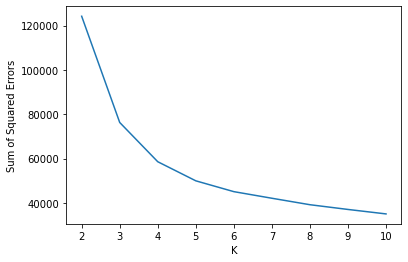

In [21]:
from sklearn.cluster import KMeans

def plot_sse(features_X, start=2, end=11):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(features_X)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(X_complete)

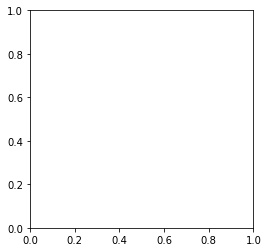

In [22]:
fig, axs = plt.subplots(1, 1, figsize=(4,4), sharey=True)

# Plot the clusters with K = 3
labels = KMeans(n_clusters=3, random_state=0).fit_predict(X_complete)
#axs.scatter(X_complete[:,0], X_complete[:,1], c=labels, alpha=0.6)

In [24]:
from sklearn.decomposition import PCA

X_reduced_pca = PCA(n_components=3).fit(X_complete).transform(X_complete)

print("The features of the first sample are: %s" % X_reduced_pca[0])

The features of the first sample are: [11.97071719  3.92736   ]


Text(0.5, 0, 'PCA')

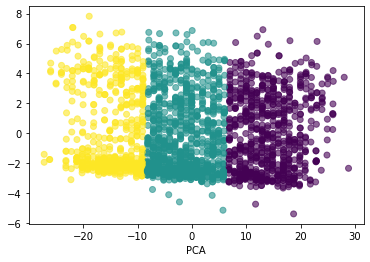

In [27]:
# Plot the data reduced in 2d space with PCA
plt.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=labels, alpha=0.6)
plt.xlabel("PCA")


In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

x = np.random.rand(20)
y = np.random.rand(20)
z = x*y

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z,
           linewidths=1, alpha=.7,
           edgecolor='k',
           s = 200,
           c=z)
plt.show()


## Supervised Learning

In [ ]:
# Split data in training and testing sets (80% train - 20% test)
x_train, x_test, y_train, y_test = train_test_split(data, y_online, test_size = 0.20)

### Standarization

In [ ]:
# Standarize data
numeric_columns = ['Income','Seniority','Total_Spent', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'Web_Purchases', 'Catalog_Purchases', 'Store_Purchases', 'Web_Visits_Month']
scaler = StandardScaler()

X_Train_Standarized = scaler.fit(x_train[numeric_columns]).transform(x_train[numeric_columns])
X_Test_Standarized = scaler.transform(x_test[numeric_columns])
X_Train_Standarized

In [ ]:
#Concat standarized data with dummy/indicator variables
cat_cols = [c for c in x_train.columns if c not in numeric_columns]
X_Train_Standarized = pd.DataFrame(X_Train_Standarized, columns=numeric_columns)
X_Train_complete = pd.concat([X_Train_Standarized, x_train[cat_cols].reset_index(drop=True)], axis=1)
X_Train_complete

X_Test_Standarized = pd.DataFrame(X_Test_Standarized, columns=numeric_columns)
X_Test_complete = pd.concat([X_Test_Standarized, x_test[cat_cols].reset_index(drop=True)], axis=1)
X_Test_complete